# Проект: Анализ и предсказание успешности стартапов

Проект представляет собой исследовательскую работу, цель которой - анализ псевдо-реальных данных о стартапах, функционировавших в период с 1980 по 2018 годы, с целью предсказания, какие из них закроются. Псевдо-реальные данные - это данные, которые являются реальными, но с добавлением синтетической составляющей, что позволяет моделировать различные сценарии и условия для более точного анализа.

**Цель** - разработать модель для предсказания успешности стартапа (закроется или нет)

Датасет состоит из двух файлов: тренировочный набор (около 53к записей) и тестовый набор (около 13к записей). Тренировочный набор содержит целевой признак `status`, указывающий на то, закрылся стартап или продолжает действовать. Временной период - '1970-01-01' по '2018-01-01'. Дата формирования выгрузки - '2018-01-01'

**Описание полей данных** \
`name` - Название стартапа \
`category_list` - Список категорий, к которым относится стартап \
`funding_total_usd` - Общая сумма финансирования в USD \
`status` - Статус стартапа (закрыт или действующий) \
`country_code` - Код страны \
`state_code` - Код штата \
`region` - Регион \
`city` - Город \
`funding_rounds` - Количество раундов финансирования \
`founded_at` - Дата основания \
`first_funding_at` - Дата первого раунда финансирования \
`last_funding_at` - Дата последнего раунда финансирования \
`closed_at` - Дата закрытия стартапа (если применимо)

## Загрузка и ознакомление с данными

In [1]:
!pip install phik -q
!pip install scikit-learn==1.1.3 -q
!pip install imblearn -q

In [2]:
!pip install seaborn --upgrade

In [3]:
# импорт библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import phik
import statsmodels.api as sm
import shap


import warnings

from scipy import stats
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score, precision_score, accuracy_score, confusion_matrix, roc_auc_score, f1_score
from scipy.stats import t, lognorm
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder,
    LabelEncoder,
    StandardScaler, 
    MinMaxScaler,
    RobustScaler
)
 
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.impute import SimpleImputer

from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier


from imblearn.over_sampling import RandomOverSampler

# игнорировать все предупреждения
warnings.filterwarnings("ignore")

C:\Users\mikha\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [4]:
# напишем функцию которая выведет нам все нужные данные.
def data_info(data):
    try:
        print('Первые десять строк данных:')
        display(data.head(10))
        print('Общая информацию о датафрейме')
        display(data.info())
    except:
        return 'Проверьте параметры'

In [5]:
# напишем функцию которая выведет пропуски в данных
def nulls_info(data, data_name):
    try:
        display(f'Количество пропусков в данных {data_name}')
        display(data.isna().sum())
    except:
        return 'Проверьте параметры'

In [6]:
# определим функцию для поиска и удаления явных дубликатов
def drop_dupl(df, df_name):
    object_columns = df.select_dtypes(include=['object']).columns
    df[object_columns] = df[object_columns].apply(lambda x: x.str.lower())
    a = df.duplicated().sum()
    print(f'Кол-во явных дубликатов в датафрейме {df_name}:', a)
    if a > 0:
        print(f'Удалено {a} дубликатов')
        df.drop_duplicates(inplace=True, ignore_index=True)

In [7]:
# определим функцию для просмотра распределений признаков 
def data_search(df, df_name):
    print(f'Описание количественных признаков в датафрейме {df_name}')
    display(df.describe().round(2))
    print(f'Описание категориальных признаков в датафрейме {df_name}')
    display(df.describe(include='object').round(2))


In [8]:
# тест Хемпеля
def hampel(vals_orig):
    vals = vals_orig.copy()    
    difference = np.abs(vals.median()-vals)
    median_abs_deviation = difference.median()
    threshold = 3 * median_abs_deviation
    outlier_idx = difference > threshold
    vals[outlier_idx] = -99 #np.nan
    return(vals)

In [9]:
def plot_hist_box(df, y):
    # определение числовых колонок
    numeric_columns = df.select_dtypes(include=['int', 'float']).columns
    
    # исключение колонки 'id', если она есть в числовых колонках
    if 'id' in numeric_columns:
        numeric_columns = numeric_columns.drop('id')

    # если нет числовых колонок, выход из функции
    if len(numeric_columns) == 0:
        print("Нет числовых колонок для отображения.")
        return

    # формирование полотна для графиков
    m = len(numeric_columns)
    n = 2  # два графика для каждой числовой переменной
    fig, axes = plt.subplots(m, n, figsize=(15, 5*m))

    # если есть всего одна числовая колонка, решаем проблему одномерного массива
    if len(numeric_columns) == 1:
        for i, column in enumerate(numeric_columns):
              # гистограмма
            sns.histplot(data=df, x=column, kde=True, hue=y, bins=15, ax=axes[i])
            axes[i].set_title(f'Гистограмма {column}')

             # boxplot
            sns.boxplot(data=df, x=df[column], y=y, ax=axes[i + len(numeric_columns)])
            axes[i + len(numeric_columns)].set_title(f'Боксплот {column}')
    else:

        # построение графиков
        for i, column in enumerate(numeric_columns):
            # гистограмма
            sns.histplot(data=df, x=column, hue=y, kde=True, ax=axes[i, 0])
            axes[i, 0].set_title(f'Гистограмма {column}')

            # boxplot
            sns.boxplot(data=df, x=df[column], y=y, ax=axes[i, 1])
            axes[i, 1].set_title(f'Боксплот {column}')

    # регулировка расположения графиков
    plt.tight_layout()
    plt.show()


In [10]:
# определим функцию для отрисовки столбчатых диаграмм
def plot_bar_charts(dataframe, y):
    # выбор категориальных признаков
    categorical_columns = dataframe.select_dtypes(include=['object']).columns

    # если нет категориальных колонок, выход из функции
    if len(categorical_columns) == 0:
        print("Нет категориальных колонок для отображения.")
        return

    n_rows = (len(categorical_columns) + 2) // 3
    n_cols = min(len(categorical_columns), 3)

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
    
    
    if len(categorical_columns) == 1:
        for i, column in enumerate(categorical_columns):
            sns.countplot(data=dataframe, x=column, hue=y, palette='viridis')
            axes.set_title(column)
            plt.setp(axes.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
            axes.set_xlabel('')
    else:
        axes = axes.flatten()
        for i, column in enumerate(categorical_columns):
            sns.countplot(data=dataframe, x=column, hue=y, ax=axes[i], palette='viridis')
            axes[i].set_title(column)
            plt.setp(axes[i].get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
            axes[i].set_xlabel('')

        for j in range(len(categorical_columns), n_rows * n_cols):
            fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()


In [11]:
# чтение и запись данных
train = pd.read_csv(r"C:\Users\mikha\Downloads\kaggle_startups_train_01.csv", sep=',') 


In [12]:
test = pd.read_csv(r"C:\Users\mikha\Downloads\kaggle_startups_test_01.csv", sep=',')     

In [13]:
data_info(train)

Первые десять строк данных:


,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at
0,Lunchgate,Online Reservations|Restaurants,828626.0,operating,CHE,25,Zurich,Zürich,2,2010-06-24,2011-05-01,2014-12-01,NaN
1,EarLens,Manufacturing|Medical|Medical Devices,42935019.0,operating,USA,CA,SF Bay Area,Redwood City,4,2005-01-01,2010-05-04,2014-02-25,NaN
2,Reviva Pharmaceuticals,Biotechnology,35456381.0,operating,USA,CA,SF Bay Area,San Jose,3,2006-01-01,2012-08-20,2014-07-02,NaN
3,Sancilio and Company,Health Care,22250000.0,operating,NaN,NaN,NaN,NaN,3,2004-01-01,2011-09-01,2014-07-18,NaN
4,WireTough Cylinders,Manufacturing,NaN,operating,USA,VA,VA - Other,Bristol,1,2010-07-30,2012-02-01,2012-02-01,NaN
5,Connected Sports Ventures,Mobile,4300000.0,operating,USA,NJ,Newark,Princeton,1,2011-04-21,2012-11-12,2012-11-12,NaN
6,Attensity,Analytics|Business Analytics|Social CRM|Social...,90000000.0,operating,USA,CA,SF Bay Area,Redwood City,1,2000-01-01,2014-05-14,2014-05-14,NaN
7,Mesh Networks,Software,4300000.0,operating,USA,TX,Houston,Houston,1,2005-01-01,2014-11-09,2014-11-09,NaN
8,AngioScore,Biotechnology,42000000.0,operating,USA,CA,SF Bay Area,Fremont,2,2003-01-01,2007-10-09,2011-04-20,NaN
9,Vidatronic,Semiconductors,1250500.0,operating,USA,TX,Austin,College Station,2,2010-01-01,2011-08-23,2013-03-21,NaN


Общая информацию о датафрейме
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52879 entries, 0 to 52878
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               52878 non-null  object 
 1   category_list      50374 non-null  object 
 2   funding_total_usd  42753 non-null  float64
 3   status             52879 non-null  object 
 4   country_code       47351 non-null  object 
 5   state_code         46082 non-null  object 
 6   region             46489 non-null  object 
 7   city               46489 non-null  object 
 8   funding_rounds     52879 non-null  int64  
 9   founded_at         52879 non-null  object 
 10  first_funding_at   52858 non-null  object 
 11  last_funding_at    52879 non-null  object 
 12  closed_at          4962 non-null   object 
dtypes: float64(1), int64(1), object(11)
memory usage: 5.2+ MB


None

## Предварительная обработка

In [14]:
# получение данных о пропусках
nulls_info(train, 'train')

'Количество пропусков в данных train'

name                     1
category_list         2505
funding_total_usd    10126
status                   0
country_code          5528
state_code            6797
region                6390
city                  6390
funding_rounds           0
founded_at               0
first_funding_at        21
last_funding_at          0
closed_at            47917
dtype: int64

In [15]:
# приведем все значения строк к нижнему регистру и удалим лишние пробелы
train = train.applymap(lambda x: x.lower().strip() if isinstance(x, str) else x)

In [16]:
# сумму привлеченных средств отобразим в млн. --решение исключить данное действие ввиду ухудшения качества модели
#train['funding_total_usd'] = round(train['funding_total_usd']/1000000, 3)

In [17]:
# пропуски в инвестициях
print('Количество пропусков в данных о инвестициях:',
      train.loc[train['funding_total_usd'].isnull()].shape[0]
     )

print('Из них имеют статус closed:',
      train.loc[(train['funding_total_usd'].isnull()) & (train['status']=='closed')].shape[0]
     )

Количество пропусков в данных о инвестициях: 10126
Из них имеют статус closed: 1038


In [18]:
# пропуски в географии
print('Количество пропусков в данных по местоположению компании:',
      train.loc[(train['country_code'].isnull()) & 
         (train['state_code'].isnull()) &
         (train['region'].isnull()) &
         (train['region'].isnull())
         ].shape[0]
     )

print('Из них имеют статус closed:',
      train.loc[(train['country_code'].isnull()) & 
         (train['state_code'].isnull()) &
         (train['region'].isnull()) &
         (train['region'].isnull()) &
         (train['status'] == 'closed')
         ].shape[0]
     )

Количество пропусков в данных по местоположению компании: 5528
Из них имеют статус closed: 1298


Строки с пропущенными данными удалять нельзя, т.к. они содержат значительную часть закрытых компаний, информация о которых понадобится для обучения модели

In [19]:
# проверим уникальные коды стран
train['country_code'].unique()

array(['che', 'usa', nan, 'gbr', 'rus', 'esp', 'fra', 'swe', 'ind', 'kor',
       'aus', 'twn', 'chn', 'hun', 'can', 'fin', 'bra', 'egy', 'prt',
       'isr', 'chl', 'svk', 'nld', 'arg', 'are', 'jpn', 'irl', 'deu',
       'lbn', 'est', 'idn', 'bel', 'mex', 'dnk', 'ita', 'grc', 'rom',
       'tur', 'sgp', 'sau', 'khm', 'mys', 'nga', 'qat', 'vnm', 'bgr',
       'gha', 'uga', 'jor', 'aut', 'pak', 'nzl', 'hkg', 'zaf', 'lva',
       'nor', 'hrv', 'ven', 'per', 'lux', 'svn', 'pol', 'phl', 'nic',
       'cze', 'isl', 'pan', 'ury', 'bgd', 'mco', 'gtm', 'tha', 'tto',
       'ukr', 'ken', 'cri', 'dza', 'ltu', 'cym', 'mus', 'blr', 'slv',
       'col', 'mlt', 'pse', 'blz', 'cyp', 'mmr', 'mkd', 'gib', 'srb',
       'dom', 'bwa', 'blm', 'pry', 'bmu', 'tan', 'lie', 'grd', 'uzb',
       'geo', 'sen', 'alb', 'ecu', 'moz', 'lka', 'lao', 'tun', 'hnd',
       'zwe', 'bah', 'mda', 'maf', 'bhr', 'aze', 'mar', 'kwt', 'irn',
       'ggy', 'kna', 'pri', 'omn', 'kaz', 'jam', 'npl', 'arm', 'tgo',
       'rwa', '

In [20]:
# сколько компаний выходят за период с'1970-01-01' по '2018-01-01'
train.loc[((train['founded_at'] < '1970-01-01 00:00:00') | (train['founded_at'] > '2018-01-01 00:00:00')) |
         ((train['first_funding_at'] < '1970-01-01 00:00:00') | (train['first_funding_at'] > '2018-01-01 00:00:00')) |
         ((train['last_funding_at'] < '1970-01-01 00:00:00') | (train['last_funding_at'] > '2018-01-01 00:00:00')) |
         ((train['closed_at'] < '1970-01-01 00:00:00') | (train['closed_at'] > '2018-01-01 00:00:00'))
         ].shape[0]

316

In [21]:
# удалим эти строки
index_list = list(train.loc[((train['founded_at'] < '1970-01-01 00:00:00') | (train['founded_at'] > '2018-01-01 00:00:00')) |
         ((train['first_funding_at'] < '1970-01-01 00:00:00') | (train['first_funding_at'] > '2018-01-01 00:00:00')) |
         ((train['last_funding_at'] < '1970-01-01 00:00:00') | (train['last_funding_at'] > '2018-01-01 00:00:00')) |
         ((train['closed_at'] < '1970-01-01 00:00:00') | (train['closed_at'] > '2018-01-01 00:00:00'))
         ].index)

train.drop(index_list, axis=0, inplace=True)

In [22]:
# все, кто со статусом закрыт имеет дату закрытия
train.loc[train['status'] == 'closed', 'closed_at'].isnull().sum()

0

In [23]:
#все кто открыт не имеют дату закрытия
train.loc[train['status'] == 'operating', 'closed_at'].unique()

array([nan], dtype=object)

Проверка на выполнение равенства 'closed_at' > 'last_funding_at' > 'first_funding_at' > 'founded_at'

In [24]:
train.loc[train['first_funding_at'] < train['founded_at']]

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at
34,evargrah entertainment group,entertainment|games,NaN,operating,usa,ca,los angeles,los angeles,1,2013-08-13,2013-07-09,2013-07-09,NaN
75,box upon a time,fashion|retail,389454.0,operating,NaN,NaN,NaN,NaN,2,2014-04-01,2013-12-09,2014-09-09,NaN
97,"heartscape technologies, inc.",healthcare services|medical devices|technology,18400000.0,closed,usa,ny,new york city,new york,2,2005-11-01,2005-10-10,2007-04-25,2008-07-24
111,cohuman,collaboration|enterprise software|project mana...,1400000.0,operating,usa,ca,sf bay area,san francisco,2,2009-10-09,2009-09-09,2011-01-01,NaN
114,kraftwurx,3d|3d printing|diy|e-commerce|mass customizati...,1000000.0,operating,usa,tx,houston,cypress,2,2011-08-01,2006-04-01,2011-08-09,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
52728,spotplex,curated web,450000.0,closed,usa,ca,sf bay area,santa clara,1,2007-02-01,2007-01-01,2007-01-01,2008-06-15
52737,cota (cancer outcomes tracking and analysis),health care,7000000.0,operating,NaN,NaN,NaN,NaN,1,2014-10-01,2014-09-23,2014-09-23,NaN
52790,shots :),android|ios|iphone|mobile|social media|teenagers,15200000.0,operating,usa,ca,sf bay area,san francisco,3,2013-11-12,2013-11-01,2015-09-08,NaN
52804,tirendo,e-commerce,NaN,operating,deu,16,berlin,berlin,2,2011-10-01,2011-01-01,2012-02-01,NaN


Произведем замену значений в данных, где условие не выполняется

In [25]:
train['founded_at_test'] = train['founded_at']
#train['founded_at'] = train['first_funding_at']

In [26]:
index_list = list(train.loc[train['first_funding_at'] < train['founded_at']].index)
train.loc[index_list, 'founded_at'] = train.loc[index_list, 'first_funding_at']
train.loc[index_list, 'first_funding_at'] = train.loc[index_list, 'founded_at_test']

In [27]:
train.loc[train['last_funding_at'] < train['first_funding_at']] 

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at,founded_at_test
34,evargrah entertainment group,entertainment|games,NaN,operating,usa,ca,los angeles,los angeles,1,2013-07-09,2013-08-13,2013-07-09,NaN,2013-08-13
119,infinario,big data analytics,5.000000e+05,operating,svk,2,bratislava,bratislava,1,2014-10-01,2015-01-01,2014-10-01,NaN,2015-01-01
158,opicos,polling|social media,1.000000e+06,closed,arg,7,buenos aires,buenos aires,1,2012-01-01,2012-03-01,2012-01-01,2013-05-05,2012-03-01
175,goodclic,apps|mobile|mobile commerce|mobile payments|we...,1.150000e+05,closed,usa,tx,dallas,dallas,1,2010-04-10,2010-05-10,2010-04-10,2011-07-06,2010-05-10
258,tribe,brand marketing|content|marketplaces|social media,5.814352e+05,operating,aus,7,melbourne,south melbourne,1,2015-04-01,2015-06-02,2015-04-01,NaN,2015-06-02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52627,dpsi,software,NaN,operating,usa,ma,boston,somerville,1,2013-10-31,2014-01-26,2013-10-31,NaN,2014-01-26
52629,yabbedoo,android|b2b|blogging platforms|coupons|discoun...,7.028000e+05,closed,che,7,geneva,geneva,1,2011-07-11,2011-07-17,2011-07-11,2012-08-24,2011-07-17
52684,flyruby.com,curated web,3.500000e+05,operating,usa,pa,pittsburgh,pittsburgh,2,2010-04-01,2010-10-01,2010-08-01,NaN,2010-10-01
52728,spotplex,curated web,4.500000e+05,closed,usa,ca,sf bay area,santa clara,1,2007-01-01,2007-02-01,2007-01-01,2008-06-15,2007-02-01


In [28]:
train['first_funding_at_test'] = train['first_funding_at']
index_list = list(train.loc[train['last_funding_at'] < train['first_funding_at']].index)
train.loc[index_list, 'first_funding_at'] = train.loc[index_list, 'last_funding_at']
train.loc[index_list, 'last_funding_at'] = train.loc[index_list, 'first_funding_at_test']

In [29]:
train.loc[(train['closed_at'].isnull() == False) & (train['closed_at'] < train['last_funding_at'])]

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at,founded_at_test,first_funding_at_test
580,cartmomo,e-commerce|electronics|furniture|online shopping,2.500000e+04,closed,sgp,NaN,singapore,singapore,1,2004-01-01,2004-01-01,2007-01-01,2005-10-16,2007-01-01,2007-01-01
1538,datam,advertising,4.300000e+06,closed,arg,7,buenos aires,buenos aires,1,2008-06-03,2008-06-03,2010-06-01,2009-08-31,2010-06-01,2010-06-01
3317,advaliant,advertising|incentives|internet|performance ma...,1.000000e+05,closed,usa,ny,new york city,new york,1,2004-04-01,2004-04-01,2013-04-16,2005-09-17,2013-04-16,2013-04-16
4385,everfans,file sharing|mobile,5.000000e+04,closed,sgp,NaN,singapore,singapore,1,2010-06-01,2010-06-01,2012-10-01,2011-09-29,2012-10-01,2012-10-01
5651,"qingdao diancang technology infomation co,. ltd",outsourcing,3.152916e+04,closed,NaN,NaN,NaN,NaN,1,2011-11-14,2011-11-14,2014-11-24,2013-08-12,2014-11-24,2014-11-24
6353,tempolib,advertising|mobile,2.358000e+05,closed,fra,b8,marseille,marseille,1,2008-01-01,2008-01-01,2009-03-01,2009-02-07,2009-03-01,2009-03-01
9968,ohlife,email|internet,NaN,closed,NaN,NaN,NaN,NaN,1,2010-08-02,2010-08-02,2014-10-19,2012-01-26,2014-10-19,2014-10-19
10041,babelgum,mobile|television|web development,1.320000e+07,closed,gbr,h9,london,london,1,2005-06-01,2005-06-01,2007-03-01,2007-01-26,2007-03-01,2007-03-01
15269,bizmore,advice|b2b|business services|curated web|sales...,NaN,closed,usa,ca,sf bay area,san francisco,1,2007-01-01,2007-01-01,2008-11-01,2008-10-24,2008-11-01,2008-11-01
16640,gpal,e-commerce,1.000000e+06,closed,NaN,NaN,NaN,NaN,1,2004-01-01,2004-01-01,2009-11-03,2005-10-24,2009-11-03,2009-11-03


In [30]:
train['last_funding_at_test'] = train['last_funding_at']
index_list = list(train.loc[(train['closed_at'].isnull() == False) & (train['closed_at'] < train['last_funding_at'])].index)
train.loc[index_list, 'last_funding_at'] = train.loc[index_list, 'closed_at']
train.loc[index_list, 'closed_at'] = train.loc[index_list, 'last_funding_at_test']

In [31]:
train.drop(columns=['founded_at_test' ,'first_funding_at_test' ,'last_funding_at_test'], inplace=True)

In [32]:
# предобразуем форматы
train[list(train.columns)] = train[list(train.columns)].astype(
    {'name': 'object',
     'category_list': 'object',
     'funding_total_usd': 'float64',
     'status': 'object',
     'country_code': 'object',
     'state_code': 'object',
     'region': 'object',
     'city': 'object',
     'funding_rounds': 'int64',
     'founded_at': 'datetime64[ns]',
     'first_funding_at': 'datetime64[ns]',
     'last_funding_at': 'datetime64[ns]',
     'closed_at': 'datetime64[ns]'
    })

In [34]:
drop_dupl(train, 'train')

Кол-во явных дубликатов в датафрейме train: 0


## Разведочный анализ

In [35]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 52563 entries, 0 to 52878
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   name               52562 non-null  object        
 1   category_list      50097 non-null  object        
 2   funding_total_usd  42487 non-null  float64       
 3   status             52563 non-null  object        
 4   country_code       47052 non-null  object        
 5   state_code         45788 non-null  object        
 6   region             46194 non-null  object        
 7   city               46194 non-null  object        
 8   funding_rounds     52563 non-null  int64         
 9   founded_at         52563 non-null  datetime64[ns]
 10  first_funding_at   52542 non-null  datetime64[ns]
 11  last_funding_at    52563 non-null  datetime64[ns]
 12  closed_at          4943 non-null   datetime64[ns]
dtypes: datetime64[ns](4), float64(1), int64(1), object(7)
memory usage

In [36]:
data_search(train, 'train')

Описание количественных признаков в датафрейме train


,funding_total_usd,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at
count,4.248700e+04,52563.00,52563,52542,52563,4943
mean,1.823445e+07,1.74,2008-10-19 13:50:49.757433856,2011-07-24 20:43:09.928057600,2012-07-04 19:45:01.695108608,2012-01-13 08:31:33.586890496
min,1.000000e+00,1.00,1970-02-05 00:00:00,1977-05-15 00:00:00,1977-05-15 00:00:00,1983-11-21 00:00:00
25%,3.354135e+05,1.00,2006-08-08 00:00:00,2009-10-23 00:00:00,2011-02-09 00:00:00,2009-10-04 12:00:00
50%,2.000000e+06,1.00,2010-09-01 00:00:00,2012-08-01 00:00:00,2013-09-01 00:00:00,2012-09-11 00:00:00
75%,1.000000e+07,2.00,2012-12-02 12:00:00,2014-04-02 00:00:00,2014-11-19 00:00:00,2015-04-17 12:00:00
max,3.007950e+10,19.00,2015-12-01 00:00:00,2015-12-05 00:00:00,2016-04-02 00:00:00,2017-11-06 00:00:00
std,1.870298e+08,1.37,NaN,NaN,NaN,NaN


Описание категориальных признаков в датафрейме train


,name,category_list,status,country_code,state_code,region,city
count,52562,50097,52563,47052,45788,46194,46194
unique,52519,22132,2,134,300,1037,4478
top,gust,software,operating,usa,ca,sf bay area,san francisco
freq,2,3209,47620,29722,10230,6979,2829


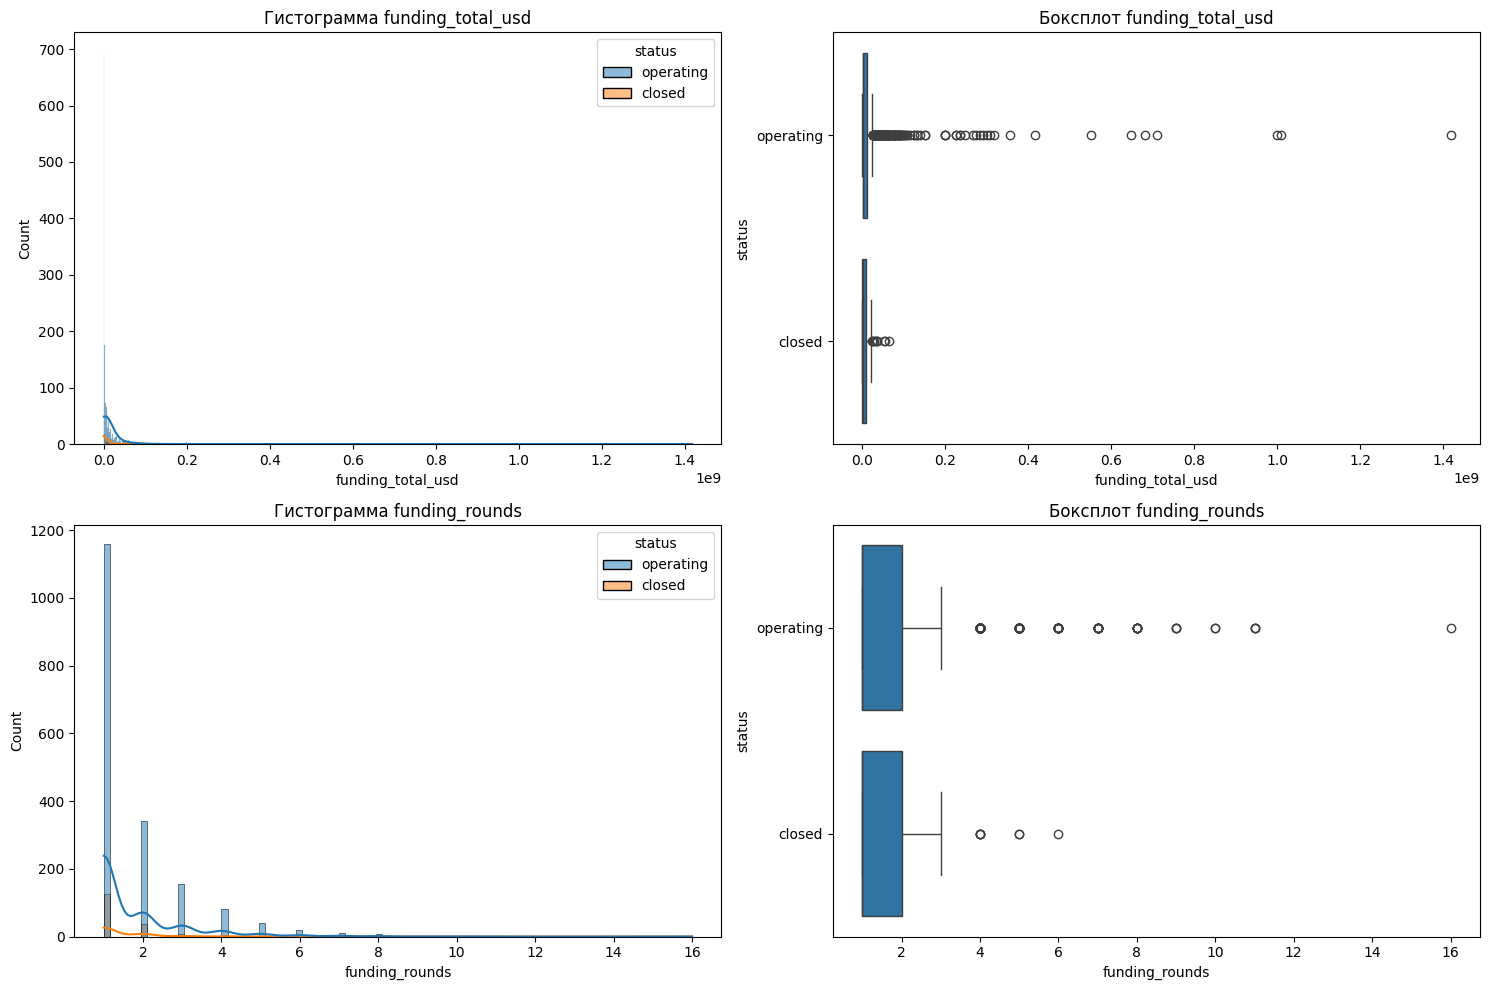

In [37]:
plot_hist_box(train.sample(2000), 'status')

In [38]:
pd.pivot_table(train, values='name',
               index=['country_code'],
               columns=['status'],
               aggfunc='count').sort_values(by='operating', ascending=False).head(10)

status,closed,operating
country_code,,
usa,2292.0,27429.0
gbr,235.0,2693.0
can,128.0,1412.0
ind,53.0,1223.0
chn,55.0,1186.0
fra,72.0,845.0
deu,61.0,774.0
isr,64.0,704.0
esp,45.0,563.0


In [39]:
# год образования стартапа
train['founded_year'] = train['founded_at'].dt.year
# год первого раунда
train['first_funding_year'] = train['first_funding_at'].dt.year
# год последнего раунда
train['last_funding_year'] = train['last_funding_at'].dt.year

In [40]:
pd.pivot_table(train, values='name',
               index=['founded_year'],
               columns=['status'],
               aggfunc='count').sort_values(by='operating', ascending=False).head(10)

status,closed,operating
founded_year,,
2013,324.0,6559.0
2012,370.0,6303.0
2011,496.0,5261.0
2014,378.0,4423.0
2010,438.0,4072.0
2009,353.0,3233.0
2008,350.0,2506.0
2007,363.0,2337.0
2006,317.0,1904.0


In [41]:
pd.pivot_table(train, values='name',
               index=['first_funding_year'],
               columns=['status'],
               aggfunc='count').sort_values(by='operating', ascending=False).head(10)

status,closed,operating
first_funding_year,,
2014.0,366.0,9060.0
2013.0,346.0,7551.0
2015.0,676.0,5797.0
2012.0,489.0,5598.0
2011.0,462.0,4500.0
2010.0,423.0,3509.0
2009.0,399.0,2790.0
2007.0,403.0,1949.0
2008.0,429.0,1898.0


In [42]:
pd.pivot_table(train, values='name',
               index=['last_funding_year'],
               columns=['status'],
               aggfunc='count').sort_values(by='operating', ascending=False).head(10)

status,closed,operating
last_funding_year,,
2014,412.0,11184.0
2015,756.0,11056.0
2013,433.0,7098.0
2012,531.0,4546.0
2011,489.0,3519.0
2010,444.0,2679.0
2009,385.0,1928.0
2008,411.0,1383.0
2007,357.0,1290.0


In [43]:
for column in train:
    if train[column].dtype in ['float64', 'int64']:
#         if column == 'funding_total_usd':
#             medians = train.groupby('funding_rounds')['funding_total_usd'].median()
#             # заполнение пропусков в funding_total_usd, используя медианные значения
#             train[column] = train.apply(lambda row: medians[row['funding_rounds']] 
#                                                      if pd.isnull(row['funding_total_usd']) 
#                                                      else row['funding_total_usd'], axis=1)
#         else:
        train[column].fillna(0, inplace=True)
    elif column == 'closed_at' and train[column].dtype in ['datetime64[ns]']:
        train[column].fillna('2200-01-01', inplace=True)
    elif column == 'first_funding_at': 
        index_list = list(train.loc[train['first_funding_at'].isnull() == True].index)
        train.loc[index_list, 'first_funding_at'] = train.loc[index_list, 'founded_at']
    else:
        train[column].fillna('no info', inplace=True)

In [44]:
''' столбец train['category_list'] содержит названия категории, разделенных | в 
формате: biotech|it|medicine. Определим топ-10 самы популярных категорий '''

# преобразуем столбец 'category_list' в список категорий
train['categories'] = train['category_list'].str.split('|')

# подсчитываем количество каждой категории
category_counts = pd.Series([category for sublist in train['categories'] for category in sublist]).value_counts()

# выбираем топ-10 категорий
top_categories = category_counts.head(10).index.tolist()
top_categories

['software',
 'mobile',
 'biotechnology',
 'e-commerce',
 'no info',
 'curated web',
 'social media',
 'enterprise software',
 'advertising',
 'health care']

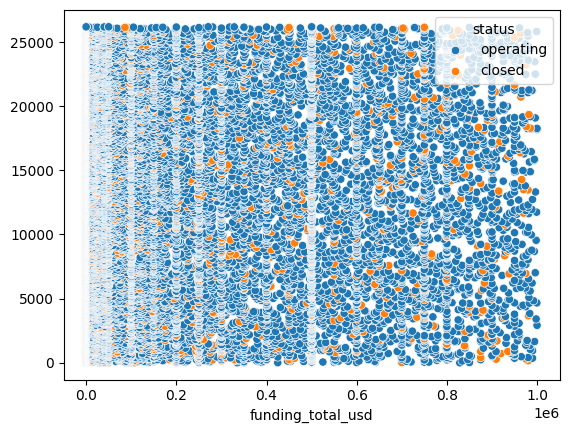

In [45]:
sns.scatterplot(data=train.loc[train['funding_total_usd'] < 1000000],
                x='funding_total_usd',
                y=range(0,len(train.loc[train['funding_total_usd'] < 1000000]))
                , hue='status')
plt.show()

## Разработка новых синтетических признаков

In [46]:
# создаем новый столбец 'is_top_category', проверяя наличие хотя бы одной из топ-10 категорий
train['is_top_category'] = train['categories'].apply(lambda x: 1 if any(category in top_categories for category in x) else 0)

In [47]:
# количество дней между датой образования стартапа и первым участием в фондах
train['datediff_first_round'] = ((train['first_funding_at'] - train['founded_at']).dt.days) + 1 
# количество дней между последним и первым раундами
train['datediff_last_round'] = ((train['last_funding_at'] - train['first_funding_at']).dt.days) + 1

# частота привлеченных средств (в день)
train['usd_per_day'] = round(train['funding_total_usd'] / train['datediff_last_round'], 5)
# частота привлеченных средств (за раунд)
train['usd_per_round'] = round(train['funding_total_usd'] / train['funding_rounds'], 5)
# преобразование даты в количество дней с 1 января 1980 года
train['days_founded_at'] = (train['founded_at'] - pd.Timestamp('1980-01-01')) / pd.Timedelta('1D')
train['days_first_funding_at'] = (train['first_funding_at'] - pd.Timestamp('1980-01-01')) / pd.Timedelta('1D')
train['days_last_funding_at'] = (train['last_funding_at'] - pd.Timestamp('1980-01-01')) / pd.Timedelta('1D')

train['funding_total_range'] = pd.cut(train['funding_total_usd'], bins=10)

In [48]:
# создадим временный DataFrame, где каждая группа по странам будет иметь количество закрытых и действующих компаний
grouped = train.groupby('country_code').apply(lambda x: pd.Series({
    'total': len(x),
    'closed': len(x[x['status'] == 'closed']),
    'operating': len(x[x['status'] == 'operating'])
})).reset_index()

# вычислим долю закрытых компаний в каждой стране
grouped['closed_rate'] = grouped['closed'] / (grouped['closed'] + grouped['operating'])

# Добавим столбец 'closed_rate' в исходный DataFrame 'train'
train = train.merge(grouped[['country_code', 'closed_rate']], on='country_code', how='left')


## Проверка на мультиколлинеарность

In [49]:
train.head()

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,...,is_top_category,datediff_first_round,datediff_last_round,usd_per_day,usd_per_round,days_founded_at,days_first_funding_at,days_last_funding_at,funding_total_range,closed_rate
0,lunchgate,online reservations|restaurants,828626.0,operating,che,25,zurich,zürich,2,2010-06-24,...,0,312,1311,632.05645,4.143130e+05,11132.0,11443.0,12753.0,"(-30079503.0, 3007950300.0]",0.087786
1,earlens,manufacturing|medical|medical devices,42935019.0,operating,usa,ca,sf bay area,redwood city,4,2005-01-01,...,0,1950,1394,30799.87016,1.073375e+07,9132.0,11081.0,12474.0,"(-30079503.0, 3007950300.0]",0.077148
2,reviva pharmaceuticals,biotechnology,35456381.0,operating,usa,ca,sf bay area,san jose,3,2006-01-01,...,1,2424,682,51988.82845,1.181879e+07,9497.0,11920.0,12601.0,"(-30079503.0, 3007950300.0]",0.077148
3,sancilio and company,health care,22250000.0,operating,no info,no info,no info,no info,3,2004-01-01,...,1,2801,1052,21150.19011,7.416667e+06,8766.0,11566.0,12617.0,"(-30079503.0, 3007950300.0]",0.234622
4,wiretough cylinders,manufacturing,0.0,operating,usa,va,va - other,bristol,1,2010-07-30,...,0,552,1,0.00000,0.000000e+00,11168.0,11719.0,11719.0,"(-30079503.0, 3007950300.0]",0.077148


interval columns not set, guessing: ['funding_total_usd', 'funding_rounds', 'founded_year', 'first_funding_year', 'last_funding_year', 'is_top_category', 'datediff_first_round', 'datediff_last_round', 'usd_per_day', 'usd_per_round', 'days_founded_at', 'days_first_funding_at', 'days_last_funding_at', 'closed_rate']


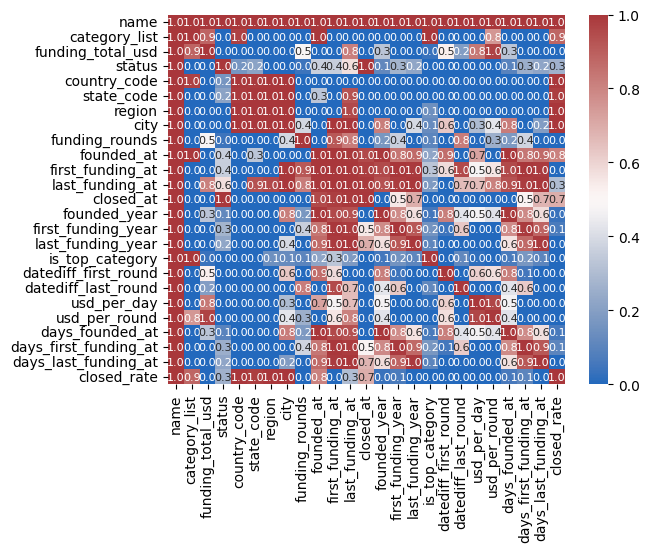

In [50]:
sns.heatmap(train.drop(columns=['categories']).sample(1500).phik_matrix(), 
            annot=True,
            fmt='.1f',
            annot_kws={'size': 8},
            cmap='vlag')
plt.show()

## Отбор финального набора обучающих признаков

Между признаками country_code, state_code, region, city есть мультиколлинеарность, а также между датами founded_at, first_funding_at, last_funding_at, closed_at и их производными признаками. Целевой признак коррелирует с переменными: 

1) country_code 0.2 \
2) founded_at 0.6 \
3) first_funding_at 0.2 \
4) last_funding_at 0.5 \
5) closed_at 1.0 (утечка целевого признака) \
6) is_top_category \
7) datediff_last_round 0.1 \
8) first_funding_year 0.1 \
9) last_funding_year 0.2 \
10) days_founded_at 0.1 \
11) days_first_funding_at 0.1 \
12) days_last_funding_at 0.2 \
13) closed_rate 0.2 

## Выбор и обучение моделей

In [51]:
RANDOM_STATE = 42
TEST_SIZE = 0.3

X = train.drop(columns=['name', 'category_list', 'categories', 'status', 'state_code', 'region', 'city', 'closed_at', 
                        'founded_at', 'first_funding_at', 'last_funding_at', 'founded_year', 'first_funding_year',
                        'last_funding_year', 'usd_per_round', 'funding_total_range'] #, 'funding_total_usd'
              )
y = train['status']

# делим датасет на тренировочную и тестовую выборки со стратификацией
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    random_state=RANDOM_STATE,
    test_size = TEST_SIZE,
    stratify=y
)

# кодируем целевой признак
label_encoder = LabelEncoder()
label_encoder.fit(y_train)

y_train = label_encoder.transform(y_train)
y_test = label_encoder.transform(y_test)

# создаем экземпляр класса RandomOverSampler с фиксированным random_state
sampler = RandomOverSampler(random_state=RANDOM_STATE)

# сэмплируем данные методов оверсэмплинга одной командой
X_train_sampled, y_train_sampled = sampler.fit_resample(X_train, y_train) 

# создаём списки с названиями признаков

ohe_columns = ['country_code'] #, 'funding_total_range'
num_columns = ['funding_rounds', 'is_top_category', 'datediff_first_round', 'datediff_last_round',
              'usd_per_day', 'days_founded_at', 'days_first_funding_at', 'days_last_funding_at', 'funding_total_usd'
               , 'closed_rate'] # 

# создаём пайплайн для подготовки признаков из списка ohe_columns: заполнение пропусков и OHE-кодирование
# SimpleImputer + OHE
ohe_pipe = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value='no info')),
     ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False))
    ]
    )

# num_pipe = Pipeline([
#     ('num_imputer', SimpleImputer(strategy='constant', fill_value=0))
# ])

# создаём общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('num', MinMaxScaler(), num_columns)
    ], 
    remainder='passthrough'
)

# создаём итоговый пайплайн: подготовка данных и модель
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

param_grid = [
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_features': range(2,5),
        'models__max_depth': range(2,5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    
#     # словарь для модели KNeighborsClassifier() 
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(5,10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']   
#     },

    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, 
            solver='liblinear', 
            penalty='l1'
        )],
        'models__C': range(1,5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    }
    
#     # словарь для модели RandomForestClassifier()
#     ,{
#         'models': [RandomForestClassifier(random_state=RANDOM_STATE)], 
#         'models__n_estimators': range(80,100),
#         'models__max_depth': range(2,5),
#         'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
#     },

#     # словарь для модели SVC()
#     {
#         'models': [SVC(C=1.0)], 
#         'models__kernel': ['linear', 'poly', 'rbf', 'sigmoid', 'precomputed']
#     }
    

]

grid = GridSearchCV(
    pipe_final, 
    param_grid=param_grid, 
    cv=5, 
    scoring='f1',  
    n_jobs = -1
)
grid.fit(X_train_sampled, y_train_sampled)

# Создание объекта RandomizedSearchCV
# randomized_search = RandomizedSearchCV(
#     pipe_final, 
#     param_distributions=param_dist, 
#     cv=5, 
#     scoring='f1',  
#     n_jobs=-1,
#     random_state=RANDOM_STATE
# )

# randomized_search.fit(X_train_sampled, y_train_sampled)

# print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
# print('Метрика лучшей модели на валидационной выборке:', randomized_search.best_score_)

print('Лучшая модель и её параметры:\n\n', grid.best_estimator_)
print ('Метрика лучшей модели на валидационной выборке:', grid.best_score_)


Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(fill_value='no '
                                                                                            'info',
                                                                                 strategy='constant')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['co

## Итоговая оценка качества предсказания лучшей модели

In [52]:
test[list(test.columns)] = test[list(test.columns)].astype(
    {'name': 'object',
     'category_list': 'object',
     'funding_total_usd': 'float64',
     #'status': 'object',
     'country_code': 'object',
     'state_code': 'object',
     'region': 'object',
     'city': 'object',
     'funding_rounds': 'int64',
     'founded_at': 'datetime64[ns]',
     'first_funding_at': 'datetime64[ns]',
     'last_funding_at': 'datetime64[ns]',
     'closed_at': 'datetime64[ns]'
    })

In [53]:
for column in test:
    if test[column].dtype in ['float64', 'int64']:
        #if column == 'funding_total_usd':
#             medians = train.groupby('funding_rounds')['funding_total_usd'].median()
#             # заполнение пропусков в funding_total_usd, используя медианные значения
#             test[column] = test.apply(lambda row: medians[row['funding_rounds']] 
#                                                      if pd.isnull(row['funding_total_usd']) 
#                                                      else row['funding_total_usd'], axis=1)
#         else:
        test[column].fillna(0, inplace=True)
    elif column == 'closed_at' and test[column].dtype in ['datetime64[ns]']:
        test[column].fillna('2200-01-01', inplace=True)
    elif column == 'first_funding_at': 
        index_list = list(test.loc[test['first_funding_at'].isnull() == True].index)
        test.loc[index_list, 'first_funding_at'] = test.loc[index_list, 'founded_at']
    else:
        test[column].fillna('no info', inplace=True)

In [54]:
# Преобразуем столбец 'category_list' в список категорий
test['categories'] = test['category_list'].str.split('|')

In [55]:
# Создаем новый столбец 'is_top_category', проверяя наличие хотя бы одной из топ-10 категорий
test['is_top_category'] = test['categories'].apply(lambda x: 1 if any(category in top_categories for category in x) else 0)
# количество дней между датой образования стартапа и первым участием в фондах
test['datediff_first_round'] = ((test['first_funding_at'] - test['founded_at']).dt.days) + 1 
test['datediff_last_round'] = ((test['last_funding_at'] - test['first_funding_at']).dt.days) + 1
test['usd_per_day'] = round(test['funding_total_usd'] / test['datediff_last_round'], 5)
test['usd_per_round'] = round(test['funding_total_usd'] / test['funding_rounds'], 5)
# Преобразование даты в количество дней с 1 января 1980 года
test['days_founded_at'] = (test['founded_at'] - pd.Timestamp('1980-01-01')) / pd.Timedelta('1D')
test['days_first_funding_at'] = (test['first_funding_at'] - pd.Timestamp('1980-01-01')) / pd.Timedelta('1D')
test['days_last_funding_at'] = (test['last_funding_at'] - pd.Timestamp('1980-01-01')) / pd.Timedelta('1D')
test['funding_total_range'] = pd.cut(test['funding_total_usd'], bins=10)

In [56]:
# создадим временный DataFrame, где каждая группа по странам будет иметь количество закрытых и действующих компаний
test = test.merge(grouped[['country_code', 'closed_rate']], on='country_code', how='left')

In [57]:
test['closed_rate'].fillna(0, inplace=True)

In [58]:
X_test = test[['country_code', 'funding_rounds', 'is_top_category', 'datediff_first_round', 'datediff_last_round',
              'usd_per_day', 'days_founded_at', 'days_first_funding_at', 'days_last_funding_at'
               #, 'funding_total_range'
               ,'funding_total_usd'
               ,'closed_rate'
              ]]  

In [59]:
# Получение лучшей модели
best_model = grid.best_estimator_

# Применение лучшей модели к тестовой выборке
predictions = grid.predict(X_test)


In [60]:
# запишем результат модели к датафрейму
decoded_predictions = label_encoder.inverse_transform(predictions)
test['status'] = decoded_predictions

In [61]:
# посмотри распределение предсказаний
test.groupby('status')['name'].count()

status
closed        1583
operating    11628
Name: name, dtype: int64

In [62]:
#test[['name', 'status']].to_csv('data.csv', index=False)
test.head()

,name,category_list,funding_total_usd,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,...,datediff_first_round,datediff_last_round,usd_per_day,usd_per_round,days_founded_at,days_first_funding_at,days_last_funding_at,funding_total_range,closed_rate,status
0,Crystalsol,Clean Technology,2819200.0,NIC,17,no info,no info,1,2008-06-01,2009-07-01,...,396,1,2.819200e+06,2819200.0,10379.0,10774.0,10774.0,"(-4715000.0, 471500000.0]",0.0,operating
1,JBI Fish & Wings,Hospitality,0.0,USA,TN,TN - Other,Humboldt,1,2010-07-25,2010-07-28,...,4,1,0.000000e+00,0.0,11163.0,11166.0,11166.0,"(-4715000.0, 471500000.0]",0.0,operating
2,COINPLUS,Finance,428257.0,LUX,3,Esch-sur-alzette,Esch-sur-alzette,2,2014-06-16,2014-05-15,...,-31,127,3.372102e+03,214128.5,12585.0,12553.0,12679.0,"(-4715000.0, 471500000.0]",0.0,operating
3,Imagine Communications,Software|Video|Video Streaming,34700000.0,USA,CA,San Diego,San Diego,4,2005-01-01,2005-01-01,...,1,1936,1.792355e+04,8675000.0,9132.0,9132.0,11067.0,"(-4715000.0, 471500000.0]",0.0,operating
4,DNA13,Software,4530000.0,CAN,ON,Ottawa,Ottawa,1,2001-01-01,2007-05-08,...,2319,1,4.530000e+06,4530000.0,7671.0,9989.0,9989.0,"(-4715000.0, 471500000.0]",0.0,operating


## Анализ важности признаков

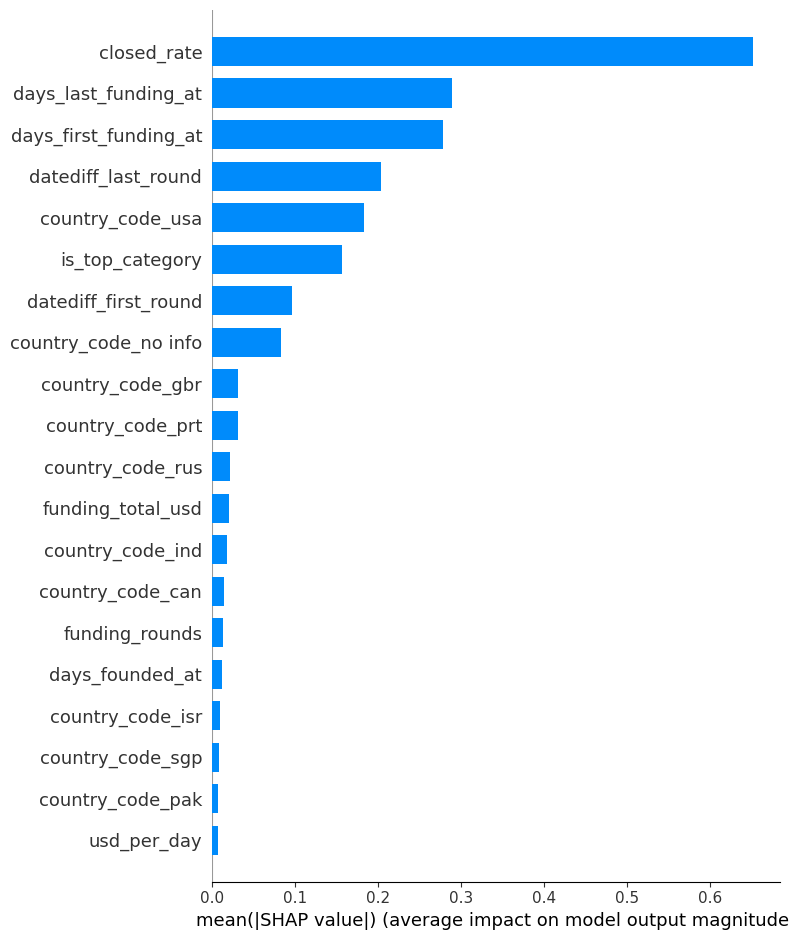

In [63]:
# Получение ColumnTransformer из пайплайна
column_transformer = best_model.named_steps['preprocessor']

all_feature_names = []

for name, transformer, columns in column_transformer.transformers_:
    if hasattr(transformer, 'get_feature_names_out'):
        # Получаем имена признаков для текущего трансформера
        feature_names = transformer.get_feature_names_out(columns)
        # Добавляем имена признаков в общий список
        all_feature_names.extend(feature_names)

# Трансформация X_train с помощью ColumnTransformer для получения обработанных признаков
X_train_processed = column_transformer.transform(X_train_sampled)

# Создание DataFrame с обработанными данными
X_train_processed_df = pd.DataFrame(X_train_processed ,
                                    columns=all_feature_names)

# График важности признаков
explainer = shap.LinearExplainer(best_model.named_steps['models'], X_train_processed_df)
shap_values = explainer.shap_values(X_train_processed_df)
shap.summary_plot(shap_values, X_train_processed_df, plot_type='bar')

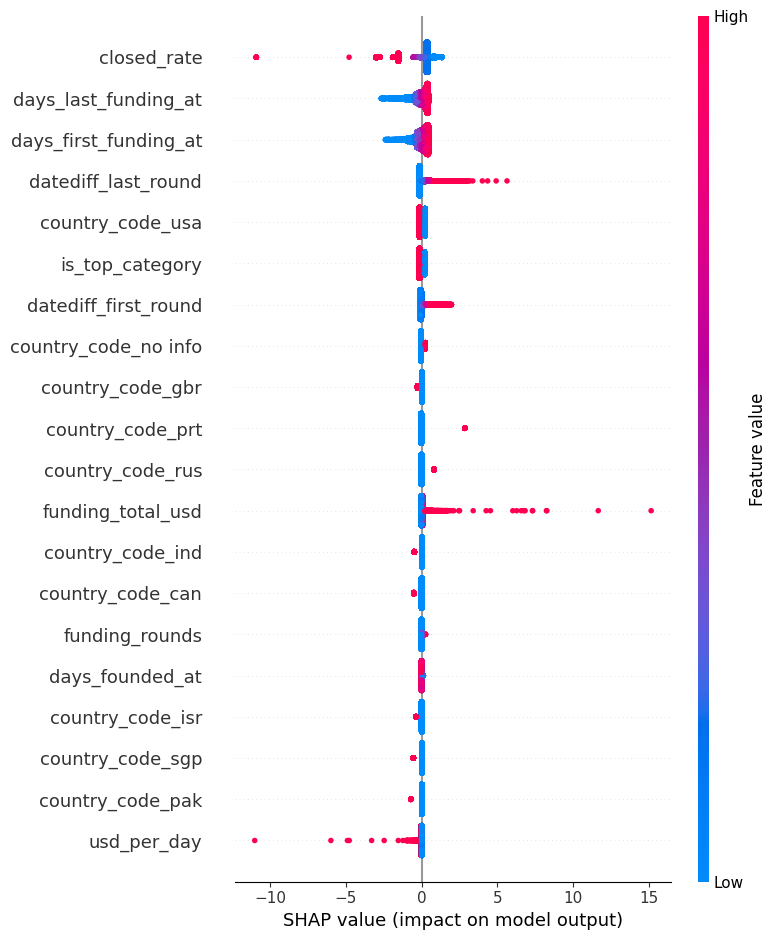

In [64]:
shap.summary_plot(shap_values, X_train_processed_df, plot_type='dot')

**На основании анализа признаков модели можно сделать следующие выводы:**
1) Топ-6 значимых признаков (по убыванию): closed_rate --> days_last_funding_at --> days_first_funding_at --> datediff_last_round --> country_code_usa --> is_top_category \
2) Чем больше значения признаков closed_rate, usd_per_day, тем меньше SHAP‑значения объектов. Если у наблюдения высокое значение этих признаков, то у него высокая вероятность принадлежности к классу 0. \
3) Чем больше значение признаков datediff_last_round, datediff_first_round, funding_total_usd тем выше SHAP-значения. Если у наблюдения высокое значение этого признака, то у него высокая вероятность принадлежности к классу 1.